In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import scipy
sys.path.append(os.path.join('..', 'importantfunctions'))
from ODEsolvers import *

Going to attempt to implement adaptive step size according to the method in the slides, rather than something like RK45. Will need to start with a problem with only a single ODE and then improve it from there. Will use the atmosphere ODE from class on 10.23.

In [4]:
#this will execute a single step of the RK4 process
def RK4step(f,r,t,h,*args):
    k1=h*f(r,t, *args)
    k2=h*f(r+0.5*k1,t+0.5*h, *args)
    k3=h*f(r+0.5*k2,t+0.5*h, *args)
    k4=h*f(r+k3,t+h, *args)
    rnew=r+(1/6)*(k1+2*k2+2*k3+k4)
    return rnew, t+h

In [5]:
def RK4doublestep(f,r,t,h,*args):
    h2=h/2
    rhalf,thalf=RK4step(f,r,t,h2,*args)
    rnew,tnew=RK4step(f,rhalf,thalf,h2,*args)
    return rnew,tnew

In [6]:
def rhoratio(x1,x2,h,tol):
    return 30*h*tol/abs(x1-x2)

In [7]:
def hprime(h,rho):
    return h*(rho**0.25)

In [8]:
def adaptivestep(f,r,t,h,tol,*args):
    x1,t1=RK4step(f,r,t,h,*args)
    x2,t2=RK4doublestep(f,r,t,h,*args)

    hog=h

    if abs(x1-x2)<1e-16: #won't be able to calculate rho if this is less than machine precision because will get divide by 0 error
        return x2,t2,h

    rho=rhoratio(x1,x2,h,tol)
    
    while rho<1:
        h=hprime(h,rho)
        x1,t1=RK4step(f,r,t,h,*args)
        x2,t2=RK4doublestep(f,r,t,h,*args)
        rho=rhoratio(x1,x2,h,tol)
        
    hnew=hprime(h,rho)
    hnew=min(hnew,hog*2) #makes sure that the returned hnew is not more than 2 times as large as the original h
    return x2,t2,hnew

In [9]:
mu=29
T=300 #K
g=9.8 #m/s^2
mp=1.67262192e-27 #kg
Kb=1.380649e-23 #J/K
P0=101325 #N/m^2
z0=0
zmax=40000 #40km in m

In [10]:
def diffeq(P, z, T, mu=mu, mp=mp, Kb=Kb, g=g):
    return (-mu*mp*g*P)/(Kb*T)

In [11]:
adaptivestep(diffeq,P0,0,1,1e-12,T) #exits fine even when x1 and x2 are very close

(101313.3718932127, 1.0, 1)

In [12]:
adaptivestep(diffeq,P0,0,100,1e-12,T) #need comically large step size to get h to start changing for this example

(100894.37016148932, 37.1103198534946, 37.17194180101357)

For loop, can't go until a certain number of steps anymore, because h is variable, so need to go to value of the independent variable (in this case Z). Will have actual function take in a t-range similar to scipy method. Also use lists to store values along the way, because appending to them is more efficient than appending to numpy arrays. Will convert to numpy arrays at the end.

In [14]:
z_list=[z0]
P_list=[P0]
h=100
tol=1e-12

In [15]:
h_list=[h]

In [16]:
while z_list[-1]<zmax:
    Pnew,znew,h=adaptivestep(diffeq,P_list[-1],z_list[-1],h,tol,T)
    P_list.append(Pnew)
    z_list.append(znew)
    h_list.append(h)

In [17]:
Ps=np.array(P_list)
Zs=np.array(z_list)
Hs=np.array(h_list)

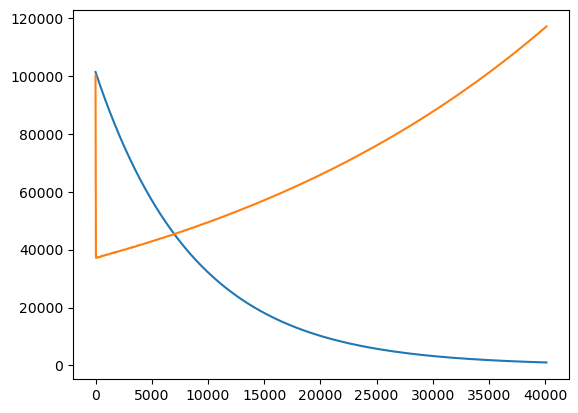

In [18]:
plt.plot(Zs,Ps)
plt.plot(Zs,Hs*1000) # *1000 is just so that they appear on similar scales

The fact that the step size increases with z makes sense given the change in slope of the line.

In [20]:
from RKadaptive import *

In [21]:
Zs,Ps=RK4adapt(diffeq,P0,[z0,zmax],T,hstart=100)

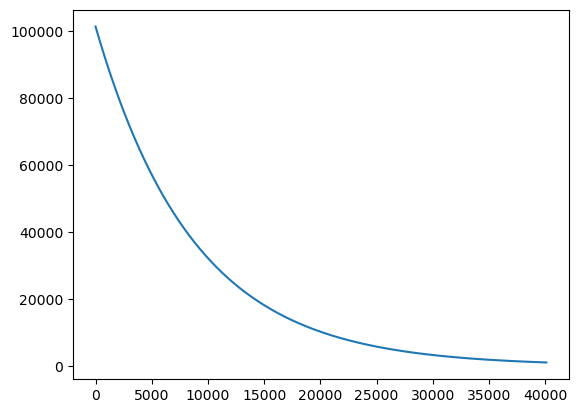

In [22]:
plt.plot(Zs,Ps)